# I. Parsing environment

In [24]:
# Demo/startup file for assignment 1 in B659 RL: Spring 2020
# To be used with python 3
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

tollerance= 0.001

# Please use this setup for assignment 1
np.random.seed(5467)

env = gym.make('FrozenLake-v0',desc=None,map_name=None)
env.seed(48304)
env._max_episode_steps = 1000

# Other environments or setups are possible
#env = gym.make('FrozenLake-v0',map_name='8x8')
#env = gym.make('CartPole-v0')

# We are not supposed to peek into the model
# But for this assignment we will
P=env.P
nA=env.nA #number of actions
nS=env.nS #number of observations
#num of states 64

# Demo of how to peek and use P
# You can run this and inspect the printout to understand the structure
# of entries in P
s=np.random.randint(nS)
a=np.random.randint(nA)
print("at state ",s," using action ",a)
print("Transition to: ",P[s][a])

at state  46  using action  1
Transition to:  [(0.3333333333333333, 45, 0.0, False), (0.3333333333333333, 54, 0.0, False), (0.3333333333333333, 47, 0.0, True)]


In [25]:
class MDP:
    def __init__(self, transition_probs, rewards, terminal_states):
        self.transition_probs = transition_probs
        self.rewards = rewards
        self.terminal_states = terminal_states
    '''
    transition_probs = {
              's0':{
                'a0': {'s0': 0.5, 's2': 0.5},
                'a1': {'s2': 1}
              },
              's1':{
                'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
                'a1': {'s1': 0.95, 's2': 0.05}
              },
              's2':{
                'a0': {'s0': 0.4, 's1': 0.6},
                'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
              }
            }
        rewards = {
            's1': {'a0': {'s0': +5}},
            's2': {'a1': {'s0': -1}}
        }
        terminate {'s1':True, 's2':False}
    '''
    def get_all_states(self):
        '''return a tuple of all MDP states'''
        return tuple(self.transition_probs.keys())
        
        
    def get_possible_actions(self, state):
        ''' return a tuple of possible actions in a given state '''
        return tuple(self.transition_probs.get(state, {}).keys())
    
    
    def get_next_states(self, state, action):
        ''' return a dictionary of {next_state1 : Pi(s' |s, a),
            next_state2: ...} '''
        return self.transition_probs[state][action]
    
    
    def get_reward(self, state, action, next_state):
        '''return a reward if action is taken in s and the next state is s' '''
        return self.rewards.get(state, {}).get(action, {}).get(next_state,0.0)
    
    def get_transition_prob(self, state, action, next_state):
        ''' return P(s' | s, a)'''
        return self.get_next_states(state, action).get(next_state, 0.0)

In [26]:
## Get transition pobs dictionary from the env
transition_probs = {}
for state in P:
    actions={}
    for action in P[state]:
        actions[action]={next_state[1]:next_state[0] for next_state 
                         in  P[state][action]}
    transition_probs[state] = actions
    
##Get rewards from MDP states

rewards = {}
for state in P:
    actions={}
    for action in P[state]:
        actions[action]={next_state[1]:next_state[2] for next_state 
                         in  P[state][action]}
    rewards[state] = actions
    
    
##Get all the terminal states

terminal = {}
for state in P:
    for action in P[state]:
        for next_state in  P[state][action]:            
            terminal[next_state[1]] = next_state[-1] 
            
            
## Create mdp object

mdp = MDP(transition_probs, rewards, terminal)

# II. Value iteration

We know that value iteration is defined by the following equation:

$$ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

But if for a second we foget about \max here we notice that the rest of the formula is nothing but state-value function $Q_i(s, a)$ and is defined as follows:
$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

First, let us implement state-action value function.


In [27]:
def calc_action_value(mdp, state_values, curr_state, action, gamma=1):
    '''
    Calculates state-action value function for a single state Q(s,a)
    '''
    q_value = 0.0
    
    if mdp.terminal_states[curr_state]:
        return 0
    
    for next_state in mdp.get_next_states(curr_state, action):
        #Get all possible trajectories from the current state
        transition_prob = mdp.get_transition_prob(
            curr_state, 
            action, 
            next_state)
        reward = mdp.get_reward(
            curr_state,
            action,
            next_state
            )
        q_value+= transition_prob*(reward+gamma*state_values[next_state])
    return q_value

Now to get an update of state value we simply take the maximum over actions of state-action function:
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [28]:
def calc_new_state_value(mdp, state_values, state, gamma):
    '''
    Calculates the next V(s).
    '''
    if mdp.terminal_states[state]:
        return 0

    q_values = []
    for next_action in mdp.get_possible_actions(state):
        q_value = calc_action_value(mdp, state_values, 
                                       state, next_action, gamma)
        q_values.append(q_value)
        
    return max(q_values)

In [29]:
##Let's generate some state values to test both functions
test_Vs = {s:np.random.randint(low = 0, high = 5) for s in mdp.get_all_states()}

#mdp, state_values, curr_state, action, gamma
print('Q(S_4, a_2): ',calc_action_value(mdp, test_Vs, 4, 2, 1))

Q(S_4, a_2):  0.6666666666666666


Now we implement the function to select actions under optimal policy $\pi^*$ which is simply $argmax_a Q_i(s,a)$.

In [30]:
def find_optimal_action(mdp, state_values, state, gamma=1):
    '''
    Finds optimal action given updated state vaues
    '''
    if mdp.terminal_states[state]:
        return None
    
    #Save number of backups for plot 2
    num_backups = 0
    
    #Get the action which gives a max reward
    q_values = []
    next_actions = mdp.get_possible_actions(state)
    for next_action in next_actions:
        num_backups+=1
        #Belman update
        q_value = calc_action_value(mdp, state_values, state, next_action, gamma)
        q_values.append(q_value)
        
    return next_actions[np.argmax(q_values)], num_backups

In [31]:
def get_avg_reward_vi(mdp, state_values):
    #Go for 500 episodes
    
    rewards = []
    backups_num = 0
    
    for i_episode in range(500):
        observation = env.reset()
        
        episode_rewards = []
        
        for t in range(1000):
            action, backups = find_optimal_action(mdp, state_values, observation, 1)
            backups_num+=backups
            observation, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            if done:
                break
        rewards.append(sum(episode_rewards)/len(episode_rewards))
    env.close()
    
    return rewards, backups_num

Now let's combine functions into full **Value Iteration** algorithm and test on 500 episodes with 1000 time steps.

In [32]:
def value_iteration(mdp, gamma = 1, epsilon = 0.001):

    # initialize V(s) as 0
    state_values = {s: 0 for s in mdp.get_all_states()}
    
    iter_quality = []
    backups_so_far = []
    
    iter_count=0
    while True:

        # Compute new state values using the functions you defined above.
        # It must be a dict {state : float V_new(state)}
        new_state_values = {s:calc_new_state_value(mdp, state_values, s, gamma) 
                            for s in mdp.get_all_states()}

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())
        state_values = new_state_values
        
        avg_reward, num_backups = get_avg_reward_vi(mdp, state_values)
        backups_so_far.append(num_backups)
        iter_quality.append(sum(avg_reward)/len(avg_reward))
        iter_count+=1
        
        print("VI iteration # %4i   |   diff: %6.4f   |   " % (iter_count, diff), end="")
        print('-------------------------------------------------')
        print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
        print('-------------------------------------------------')
        
        if diff < epsilon:
            print("Terminated")
            return iter_quality, backups_so_far, state_values

In [ ]:
%%time
iter_quality_vi, backups_vi, optimal_state_values = value_iteration(mdp)

\*The printed output from VI was deliberately removed from the cell above as VI has a lot of iterations and it takes a lot of space tp print. The output can be seen when executing the cell.

During the execution of VI in the output we can see the change of delta `diff`, it is decreasing with the number of VI iterations while values of the states are updating.

# III. Policy Iteration

### Policy evaluation step

Let us define a policy for a given MDP and a function which calculates $V^{\pi}$ for a policy $\pi$.

$$V^{\pi}(s) = r(s, \pi(s))+\sum_{s',r}p(s', r|s,a)[r+\gamma V^{\pi}(s')]$$

The second sum of the equation is nothing but state-value function $Q_i(s, a)$ that we defined for VI.

In [34]:
def policy_eval(mdp, policy, gamma=1, epsilon=0.001):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    
    #Initialization
    state_values_old = {state:0 for state in mdp.get_all_states()}
    iter_count = 0
    
    while True:
        
        state_values_new = {}
        
        delta = 0
        
        for curr_state in mdp.get_all_states():
            v_old = state_values_old[curr_state]
            v_new = 0
            
            #Bellman backup with respect to Pi
            next_states=mdp.get_next_states(curr_state, policy[curr_state])
        
            for next_state in next_states:
                reward = mdp.get_reward(curr_state, policy[curr_state], next_state)
                next_state_val=next_states[next_state]*state_values_old[next_state]
                v_new+=reward+next_state_val
                
                ##Run single action backup eval
 
            delta = max(delta, abs(v_old - v_new))
            
            state_values_new[curr_state] = v_new
        state_values_old = state_values_new
            
        iter_count+=1
        
        if(delta < epsilon):
            break
    return state_values_old            

In [14]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

In [15]:
#Example of V_pi for random policy
policy_eval(mdp, test_policy)

{0: 0.0,
 1: 0.0004813588839518665,
 2: 0.0,
 3: 0.01405971500942798,
 4: 0.029491149258638202,
 5: 0.036652927857621975,
 6: 0.02297784895093912,
 7: 0.0,
 8: 0.0,
 9: 0.001012294118732334,
 10: 0.002604417705056026,
 11: 0.010791532188936756,
 12: 0.024748241152436228,
 13: 0.04661874566513402,
 14: 0.03360349140486165,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.007029117979840718,
 19: 0.0057642927048333886,
 20: 0.0,
 21: 0.08066250964108308,
 22: 0.07928369180180916,
 23: 0.04046551972594416,
 24: 0.0043252930897458,
 25: 0.013335757064873215,
 26: 0.01871206780389788,
 27: 0.03384433681623492,
 28: 0.07772590434956203,
 29: 0.11889208174860372,
 30: 0.12523160699804373,
 31: 0.08201694486180552,
 32: 0.0,
 33: 0.021726151707941392,
 34: 0.03697520712277202,
 35: 0.07000109119771974,
 36: 0.11613180251877323,
 37: 0.15511555537089455,
 38: 0.1772372917815327,
 39: 0.1285232495082071,
 40: 0.007860784390773468,
 41: 0.016356782501869276,
 42: 0.020014221709918237,
 43: 0.0620065370339555

### Policy iteration with policy improvement step

In [59]:
def get_avg_reward_pi(optimal_policy):    
    
    '''
    Runs evaluation at every PI iteration calculating
    average reward
    '''
    rewards = []    
    for i_episode in range(500):
        observation = env.reset()
        
        episode_rewards = []
        
        for t in range(1000):
            action = optimal_policy[observation]
            observation, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            if done:
                break
        rewards.append(sum(episode_rewards)/len(episode_rewards))
    return rewards

In [60]:
def policy_iteration(mdp, gamma=1):
    """
    Computes the whole loop for policy iteration algorithm
    :returns: a dict {state : V^pi(state) for all states}
              a dict {state : action}
              a list [avg reward for 500 episodes for every iteration]
    """
    #Initialize random policy
    policy = {s: np.random.choice(mdp.get_possible_actions(s)) 
              for s in mdp.get_all_states()}
    
    #print('Random policy: ', policy)
    
    iter_count=0
    
    iter_quality = []

    while True:
        
        policy_values = policy_eval(mdp, policy)
        
        policy_stable = True
    
        for curr_state in mdp.get_all_states():
            
            old_action = policy[curr_state]
            
            #Calculate action values
            action_values = {}
            
            for a in mdp.get_possible_actions(curr_state):
                action_values[a] = calc_action_value(mdp, policy_values, 
                                                     curr_state, a, gamma)
            #Take argmax
            best_action = max(action_values.keys(), key=(lambda k: action_values[k]))
            
            if old_action != best_action:
                #print('Old:', old_action, 'Best:', best_action)
                policy_stable = False
                
            policy[curr_state] = best_action
        #Assess policy on current iteration
        avg_reward = get_avg_reward_pi(policy)
        iter_quality.append(sum(avg_reward)/len(avg_reward))
        
        
        iter_count+=1
               
        print('PI iteration # : ', iter_count)
        print('-------------------------------------------------')
        print('Stable: ', policy_stable)
        print('Policy: ', policy)
        print('-------------------------------------------------')
        
        if policy_stable:
            return policy, policy_values, iter_quality

In [44]:
%%time
optimal_policy, v_pi, iter_quality_pi= policy_iteration(mdp)

PI iteration # :  1
-------------------------------------------------
Stable:  False
Policy:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 1, 63: 0}
-------------------------------------------------
PI iteration # :  2
-------------------------------------------------
Stable:  False
Policy:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 2, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 2, 31: 1, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 1, 38: 2, 39: 3, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 0, 47:

# III. Modified Policy Iteration

Repeat evaluation step only $m$ times.

In [54]:
def policy_eval_mpi(mdp, policy, m=15, gamma=1):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    
    #Initialization
    state_values_old = {state:0 for state in mdp.get_all_states()}
    iter_count = 0
    
    while m > 0 :        
        state_values_new = {}
        
        delta = 0
        
        for curr_state in mdp.get_all_states():
            v_old = state_values_old[curr_state]
            v_new = 0
            
            #Bellman backup with respect to Pi
            next_states=mdp.get_next_states(curr_state, policy[curr_state])
        
            for next_state in next_states:
                reward = mdp.get_reward(curr_state, policy[curr_state], next_state)
                next_state_val=next_states[next_state]*state_values_old[next_state]
                v_new+=reward+next_state_val
 
            delta = max(delta, abs(v_old - v_new))
            
            state_values_new[curr_state] = v_new
        state_values_old = state_values_new
        m-=1
            
    return state_values_old            

In [55]:
def modified_policy_iteration(mdp, gamma=1):
    """
    Computes the whole loop for policy iteration algorithm
    :returns: a dict {state : V^pi(state) for all states}
              a dict {state : action}
    """
    #Initialize random policy
    policy = {s: np.random.choice(mdp.get_possible_actions(s)) 
              for s in mdp.get_all_states()}
    
    #print('Random policy: ', policy)
    
    iter_quality = []
    
    iter_count=0
    
    while True:
        
        policy_values = policy_eval_mpi(mdp, policy)
        
        policy_stable = True
    
        for curr_state in mdp.get_all_states():
            
            old_action = policy[curr_state]
            
            #Calculate action values
            action_values = {}
            
            for a in mdp.get_possible_actions(curr_state):
                action_values[a] = calc_action_value(mdp, policy_values, 
                                                     curr_state, a, gamma)
            #Take argmax
            best_action = max(action_values.keys(), key=(lambda k: action_values[k]))
            
            if old_action != best_action:
                policy_stable = False
                
            policy[curr_state] = best_action
            
        #Assess policy on current iteration
        avg_reward = get_avg_reward_pi(policy)
        iter_quality.append(sum(avg_reward)/len(avg_reward))
        
        iter_count+=1
        
        print('MPI iteration # : ', iter_count)
        print('-------------------------------------------------')
        print('Stable: ', policy_stable)
        print('Policy: ', policy)
        print('-------------------------------------------------')
        if policy_stable:
            return policy, policy_values, iter_quality

In [56]:
optimal_policy_mpi, v_pi_mpi, iter_quality_mpi = modified_policy_iteration(mdp)

MPI iteration # :  1
-------------------------------------------------
Stable:  False
Policy:  {0: 0, 1: 0, 2: 0, 3: 2, 4: 2, 5: 2, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 3, 13: 2, 14: 0, 15: 0, 16: 0, 17: 0, 18: 2, 19: 0, 20: 0, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 2, 28: 1, 29: 2, 30: 0, 31: 3, 32: 0, 33: 2, 34: 2, 35: 2, 36: 3, 37: 2, 38: 0, 39: 3, 40: 1, 41: 2, 42: 2, 43: 3, 44: 3, 45: 2, 46: 0, 47: 0, 48: 0, 49: 2, 50: 0, 51: 0, 52: 0, 53: 2, 54: 0, 55: 0, 56: 1, 57: 2, 58: 0, 59: 0, 60: 0, 61: 0, 62: 2, 63: 0}
-------------------------------------------------
MPI iteration # :  2
-------------------------------------------------
Stable:  False
Policy:  {0: 1, 1: 0, 2: 0, 3: 2, 4: 2, 5: 2, 6: 0, 7: 0, 8: 1, 9: 2, 10: 1, 11: 1, 12: 3, 13: 2, 14: 0, 15: 0, 16: 0, 17: 0, 18: 2, 19: 0, 20: 0, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 0, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 1, 39: 3, 40: 1, 41: 2, 42: 3, 43: 3, 44: 3, 45: 2, 46: 0, 4

# V. Evaluation plots

In [57]:
def plot_results(values, xlabel, fname):

    plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(values[0], label='VI')
    plt.plot(values[1], label='PI')
    plt.plot(values[2], label='MPI')

    plt.xlabel(xlabel)
    plt.ylabel('Average reward')
    plt.legend()
    plt.savefig(xlabel+'.png')
    plt.show()

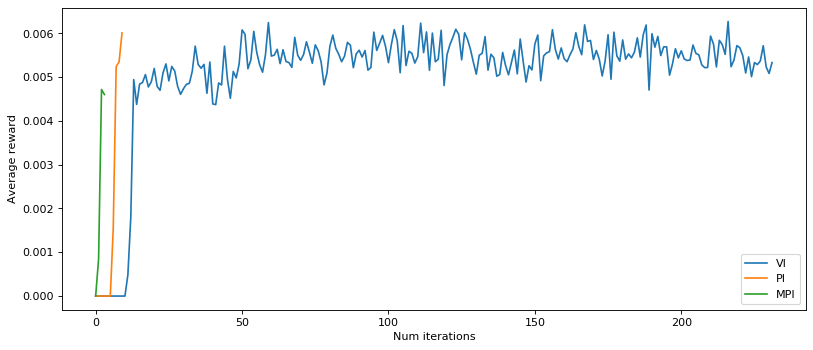

In [58]:
plot_results([iter_quality_vi, iter_quality_pi, iter_quality_mpi], 
             'Num iterations', 'iter_qual.png')